<a href="https://colab.research.google.com/github/iam-pattan/Exploring-ML/blob/main/SHAP(shaply).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://shap.readthedocs.io/en/latest/index.html

In [1]:
!pip install shap

In [ ]:
!wget 'https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv'

# TREE Models

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
np.random.seed(0)

In [6]:
# Load the data
df = pd.read_csv('/content/winequality-red.csv', sep=';') 
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# The target variable is 'quality'.
Y = df['quality']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]

In [8]:
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [9]:
# Build the model with the random forest regression algorithm:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

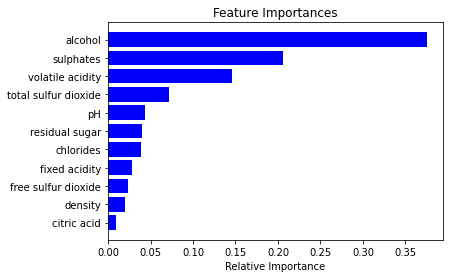

In [15]:
importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Simple viz using SHAP 😎

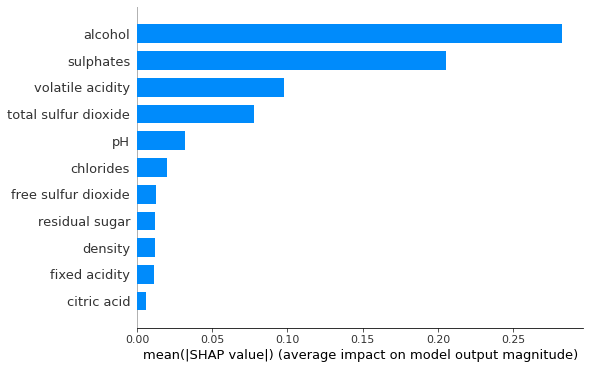

In [21]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

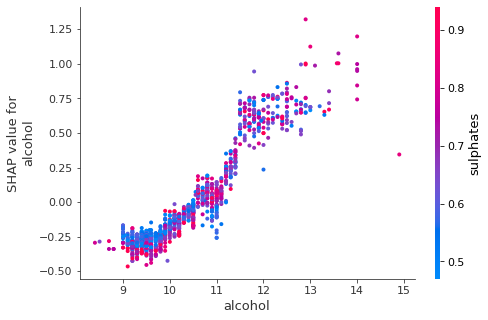

In [22]:
shap.dependence_plot("alcohol", shap_values, X_train)

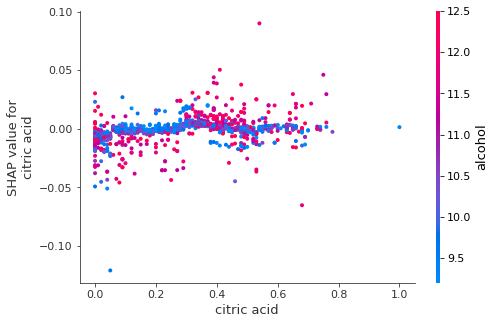

In [24]:
shap.dependence_plot("citric acid", shap_values, X_train)

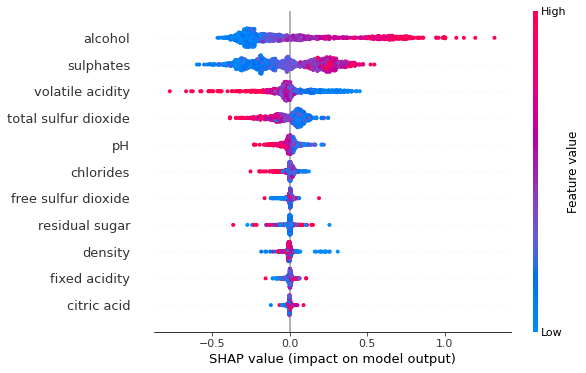

In [17]:
shap.summary_plot(shap_values, X_train)

In [26]:

X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,predict
1032,8.1,0.820,0.00,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,4.50
34,5.2,0.320,0.25,1.8,0.103,13.0,50.0,0.99570,3.38,0.55,9.2,5.35
1508,7.1,0.270,0.60,2.1,0.074,17.0,25.0,0.99814,3.38,0.72,10.6,6.26
1479,8.2,0.280,0.60,3.0,0.104,10.0,22.0,0.99828,3.39,0.68,10.6,5.93
866,6.8,0.490,0.22,2.3,0.071,13.0,24.0,0.99438,3.41,0.83,11.3,6.33
1519,6.6,0.700,0.08,2.6,0.106,14.0,27.0,0.99665,3.44,0.58,10.2,5.47
1193,6.4,0.885,0.00,2.3,0.166,6.0,12.0,0.99551,3.56,0.51,10.8,4.51


In [30]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [33]:
X_train.mean(), Y_test.mean()

(fixed acidity            8.337373
 volatile acidity         0.530000
 citric acid              0.272181
 residual sugar           2.553167
 chlorides                0.087024
 free sulfur dioxide     16.032838
 total sulfur dioxide    47.114152
 density                  0.996757
 pH                       3.309828
 sulphates                0.659077
 alcohol                 10.413995
 dtype: float64, 5.59375)

In [32]:
shap.initjs()
shap_plot(0)

In [35]:
shap.initjs()
shap_plot(4)

# LINEAR Models

In [36]:
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)

In [39]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [41]:
explainer = shap.KernelExplainer(knn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [42]:
shap.initjs()
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# DEEP LEARNING Models
Here comes the interesting stuff.....😉

In [10]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras  import datasets, layers, models
import tensorflow_datasets as tfds

In [3]:
(x_train, y_train),(x_test, y_test) = datasets.cifar10.load_data()
x_train , x_test= x_train/255.0 , x_test/255.0

170500096/170498071 [==============================] - 2s 0us/step


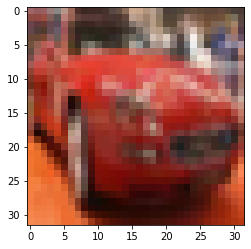

In [36]:
plt.imshow(x_train[5])

In [4]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout (0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=15)

Epoch 1/15
782/782 [==============================] - 40s 9ms/step - loss: 1.7738 - accuracy: 0.3537 - val_loss: 1.2454 - val_accuracy: 0.5521
Epoch 2/15
782/782 [==============================] - 6s 8ms/step - loss: 1.1830 - accuracy: 0.5802 - val_loss: 1.0993 - val_accuracy: 0.6169
Epoch 3/15
782/782 [==============================] - 6s 8ms/step - loss: 0.9950 - accuracy: 0.6501 - val_loss: 0.9766 - val_accuracy: 0.6574
Epoch 4/15
782/782 [==============================] - 6s 8ms/step - loss: 0.8736 - accuracy: 0.6915 - val_loss: 0.9753 - val_accuracy: 0.6616
Epoch 5/15
782/782 [==============================] - 6s 8ms/step - loss: 0.7522 - accuracy: 0.7355 - val_loss: 0.9492 - val_accuracy: 0.6700
Epoch 6/15
782/782 [==============================] - 6s 8ms/step - loss: 0.6811 - accuracy: 0.7625 - val_loss: 0.9585 - val_accuracy: 0.6662
Epoch 7/15
782/782 [==============================] - 6s 8ms/step - loss: 0.6168 - accuracy: 0.7834 - val_loss: 0.9425 - val_accuracy: 0.6880
Epoch

In [8]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 1.5345 - accuracy: 0.6644


[1.5344876050949097, 0.6643999814987183]

In [28]:
# ...or pass tensors directly
shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [31]:
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test[1:5])

array([[[[0.97647059, 0.98039216, 0.98823529],
         [0.96470588, 0.96862745, 0.97647059],
         [0.96862745, 0.97254902, 0.98039216],
         ...,
         [0.92156863, 0.9254902 , 0.93333333],
         [0.91372549, 0.91764706, 0.9254902 ],
         [0.90980392, 0.91372549, 0.92156863]],

        [[0.94117647, 0.94509804, 0.95294118],
         [0.92941176, 0.93333333, 0.94117647],
         [0.92941176, 0.93333333, 0.94117647],
         ...,
         [0.94509804, 0.94901961, 0.95686275],
         [0.94117647, 0.94509804, 0.95294118],
         [0.94117647, 0.94509804, 0.95294118]],

        [[0.94117647, 0.94509804, 0.95294118],
         [0.9372549 , 0.94117647, 0.94901961],
         [0.94117647, 0.94509804, 0.95294118],
         ...,
         [0.95686275, 0.96078431, 0.96862745],
         [0.95294118, 0.95686275, 0.96470588],
         [0.95294118, 0.95686275, 0.96470588]],

        ...,

        [[0.54901961, 0.57647059, 0.61176471],
         [0.54117647, 0.56862745, 0.60392157]

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
array([[[[0.92156863, 0.92156863, 0.92156863],
         [0.90588235, 0.90588235, 0.90588235],
         [0.90980392, 0.90980392, 0.90980392],
         ...,
         [0.91372549, 0.91372549, 0.91372549],
         [0.91372549, 0.91372549, 0.91372549],
         [0.90980392, 0.90980392, 0.90980392]],

        [[0.93333333, 0.93333333, 0.93333333],
         [0.92156863, 0.92156863, 0.92156863],
         [0.92156863, 0.92156863, 0.92156863],
         ...,
         [0.9254902 , 0.9254902 , 0.9254902 ],
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


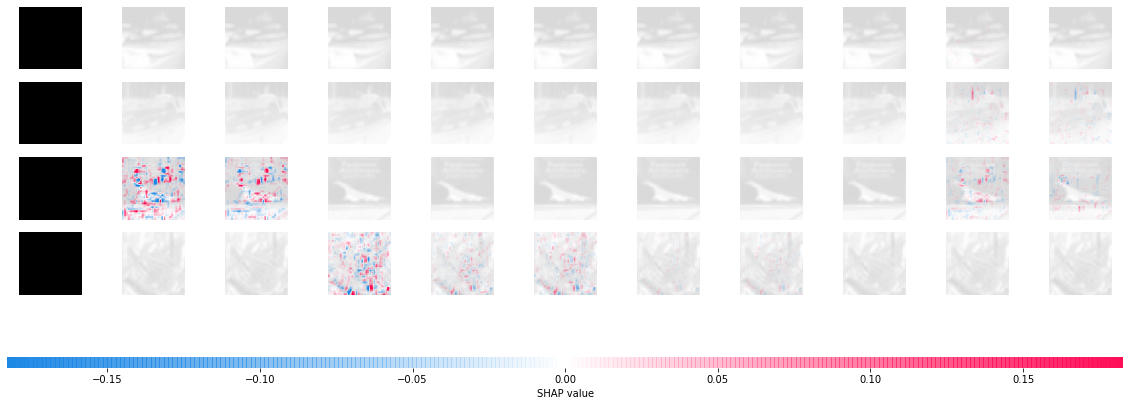

In [32]:
shap.image_plot(shap_values, -x_test[1:5])

Ref: [Article](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)